# Problem Statement:

### Given Clinical Paramater about a Patient, Can we predict whether or not they have Heart Diseases or not?




Data Dictionary

age: Displays the age of the individual.

sex: Displays the gender of the individual using the following format : 1 = male 0 = female

Chest-pain type: displays the type of chest-pain experienced by the individual using the following format : 0 = typical angina 1 = atypical angina 2 = non — anginal pain 3 = asymptotic

Resting Blood Pressure: displays the resting blood pressure value of an individual in mmHg (unit). anything above 130-140 is typically cause for concern.

Serum Cholestrol: displays the serum cholesterol in mg/dl (unit)

 Fasting Blood Sugar: compares the fasting blood sugar value of an individual with 120mg/dl. If fasting blood sugar > 120mg/dl then : 1 (true) else : 0 (false) '>126' mg/dL signals diabetes

Resting ECG : displays resting electrocardiographic results 0 = normal 1 = having ST-T wave abnormality 2 = left ventricular hyperthrophy

Max heart rate achieved : displays the max heart rate achieved by an individual.

Exercise induced angina : 1 = yes 0 = no

ST depression induced by exercise relative to rest: displays the value.

Slope of the peak exercise ST segment : 0 = upsloping: better heart rate with excercise (uncommon) 1 = flat: minimal change (typical healthy heart) 2 = downsloping: signs of unhealthy heart


Heart Disease : Displays whether the individual is suffering from heart disease or not : 1 = yes 0 = no.

# Import Tools Needed

In [2]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


# Import the Libraries

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats.mstats import winsorize
from pandas.api.types import CategoricalDtype

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Model Import
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import pickle

# Model Evaluation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

import pickle

# Load the Data

In [87]:
data = pd.read_csv('heart.csv')

In [88]:
data.shape

(918, 12)

In [89]:
data['HeartDisease'].value_counts()

,count
HeartDisease,
1,508
0,410


In [90]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


# Data Pre-processing

## Data Cleaning

In [92]:
data['Sex'] = data['Sex'].replace({'F':1,'M': 0})
data['ExerciseAngina'] = data['ExerciseAngina'].replace({'N': 0, 'Y': 1})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 86.2+ KB


# Feature Engineering

In [93]:
data['Cholesterol_Age_Ratio'] = data['Cholesterol'] / data['Age']
data['MaxHR_Age_Ratio'] = data['MaxHR'] / data['Age']

def categorize_age(age):
    if age <= 40:
        return 'Young'
    elif 40 < age <= 60:
        return 'Middle-aged'
    else:
        return 'Senior'

data['AgeGroup'] = data['Age'].apply(categorize_age)
AgeGroup_order = CategoricalDtype(categories=['Young', 'Middle-aged', 'Senior'], ordered=True)
data['Age_bracket'] = data['AgeGroup'].astype(AgeGroup_order)

In [94]:
data['AgeGroup'].value_counts()

,count
AgeGroup,
Middle-aged,604
Senior,221
Young,93


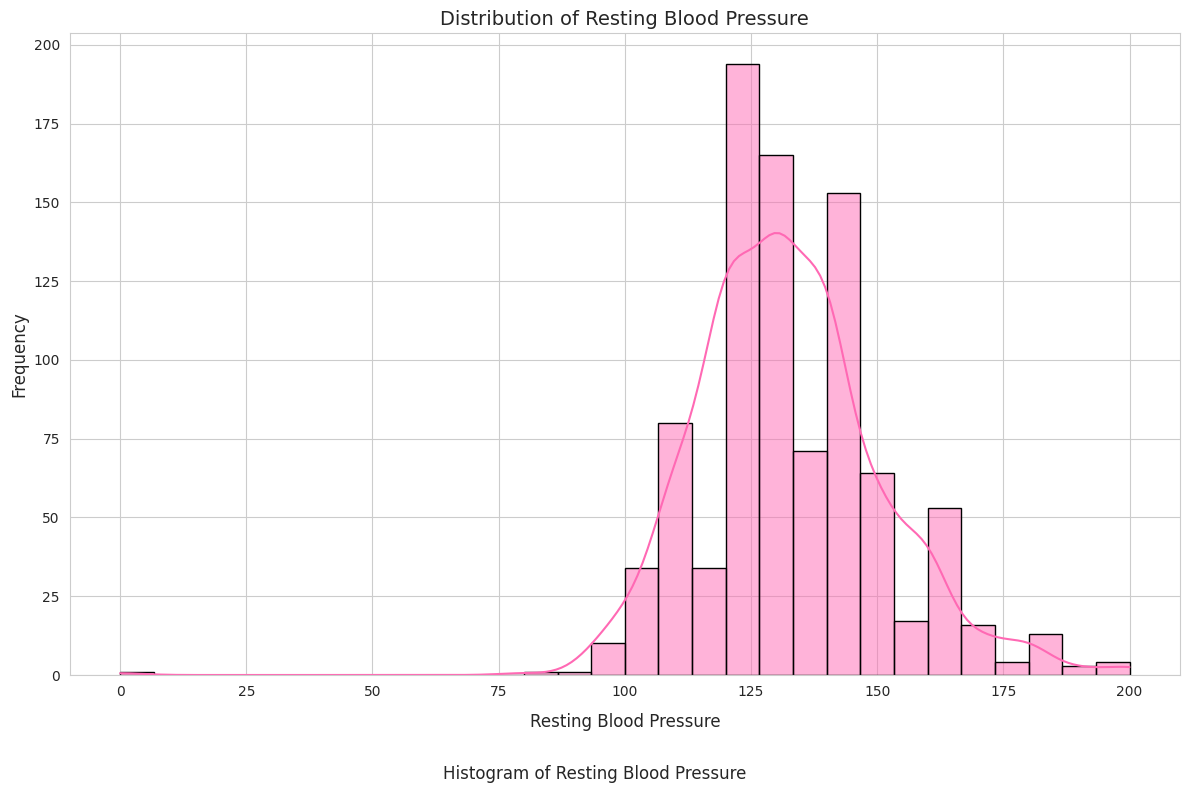

In [95]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
sns.histplot(data['RestingBP'],bins=30, kde=True, edgecolor='black', color='hotpink')

plt.xlabel('Resting Blood Pressure', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Resting Blood Pressure', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.figtext(0.5, 0.02, 'Histogram of Resting Blood Pressure', ha='center', fontsize=12)

plt.show()

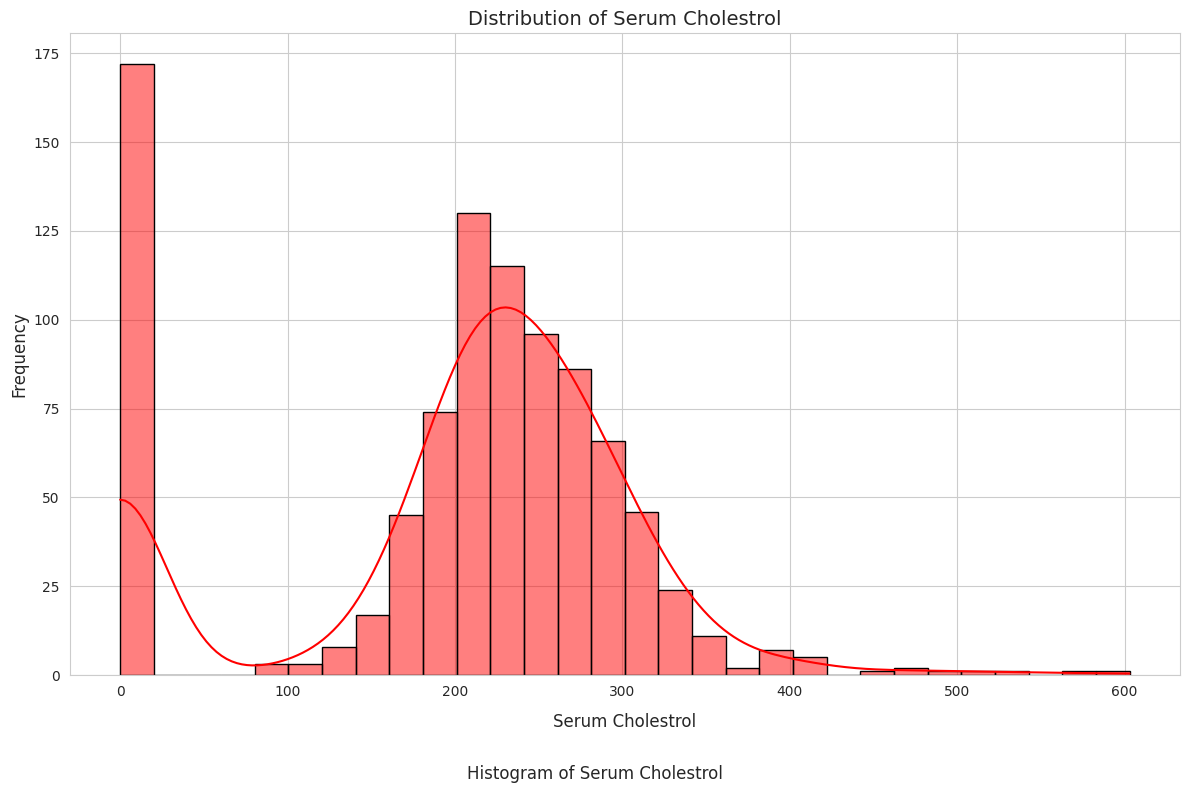

In [96]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
sns.histplot (data['Cholesterol'], bins=30, kde=True, edgecolor='black', color='red')

plt.xlabel('Serum Cholestrol', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Serum Cholestrol', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.figtext(0.5, 0.02, 'Histogram of Serum Cholestrol', ha='center', fontsize=12)

plt.show()

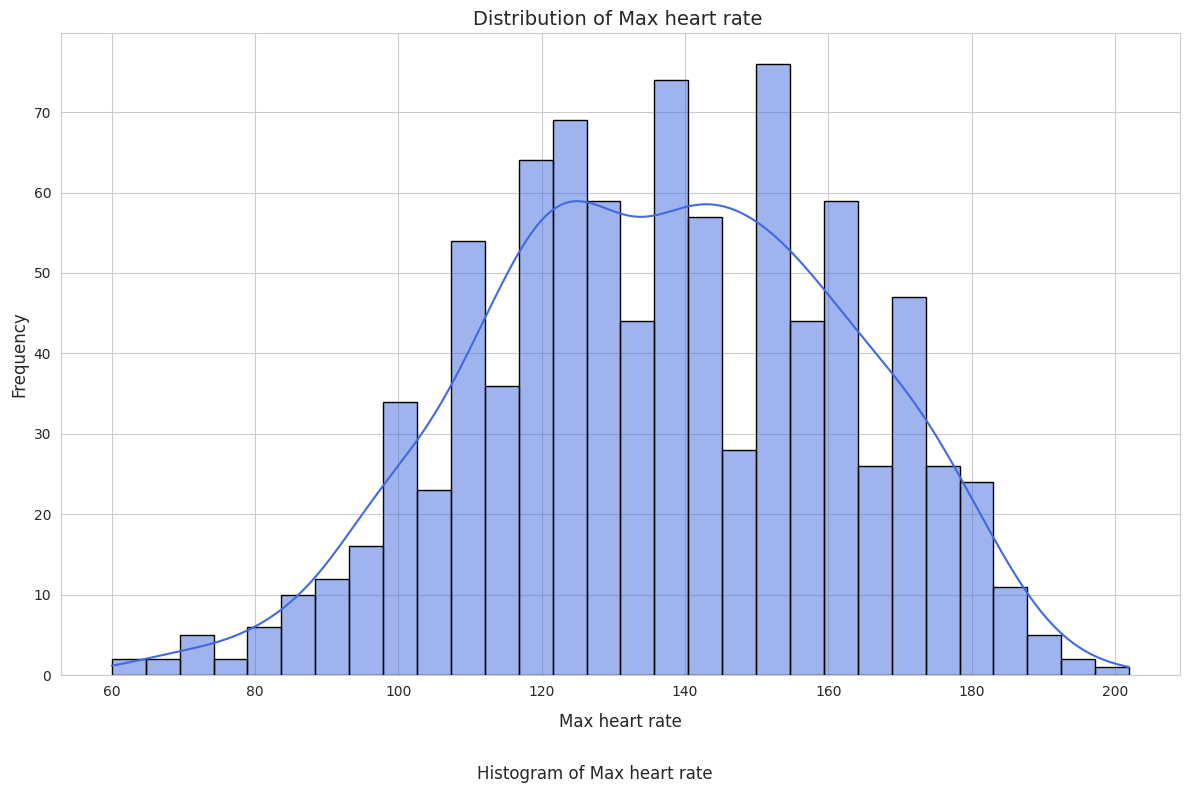

In [97]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
sns.histplot(data['MaxHR'], bins=30, kde=True, edgecolor='black', color='royalblue')

plt.xlabel('Max heart rate', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Max heart rate ', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.figtext(0.5, 0.02, 'Histogram of Max heart rate', ha='center', fontsize=12)

plt.show()

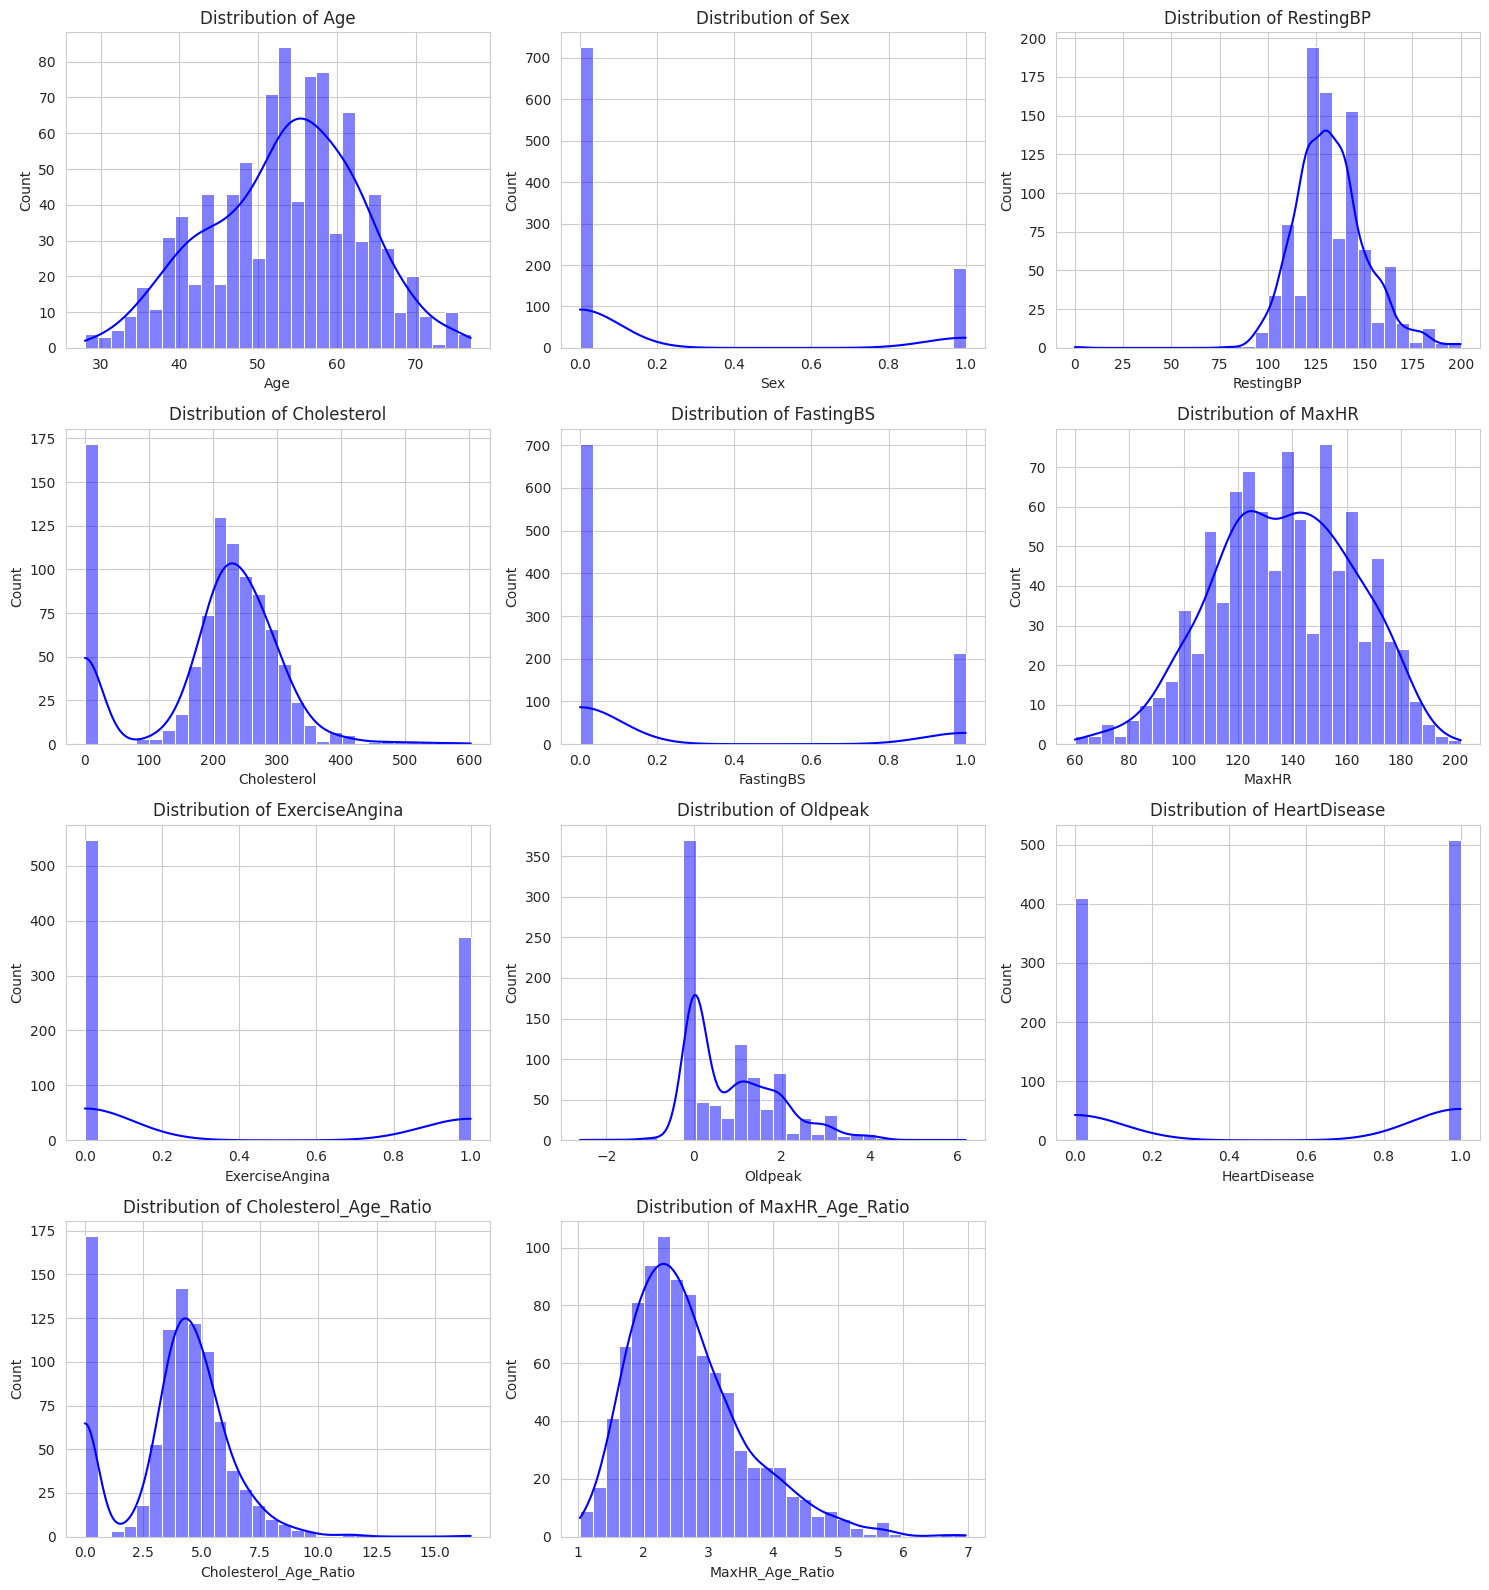

In [98]:
numerical_cols = data.select_dtypes(include=['int64', 'float64','bool']).columns


num_features = len(numerical_cols)
num_rows = int(np.ceil(num_features / 3))

plt.figure(figsize=(15, num_rows * 4))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(num_rows, 3, i)
    sns.histplot(data[col], bins=30, kde=True, color='blue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

# Outlier Treatment

In [101]:
# Clipping
data["RestingBP"] = data["RestingBP"].clip(lower=80, upper=180)

# winsorize
data["Cholesterol"] = winsorize(data["Cholesterol"], limits=[0.01, 0.05])
data["Cholesterol_Age_Ratio"] = winsorize(data["Cholesterol_Age_Ratio"], limits=[0.01, 0.05])
data["MaxHR_Age_Ratio"] = winsorize(data["MaxHR_Age_Ratio"], limits=[0.01, 0.05])
data["RestingBP"] = winsorize(data["RestingBP"], limits=[0.01, 0.05])

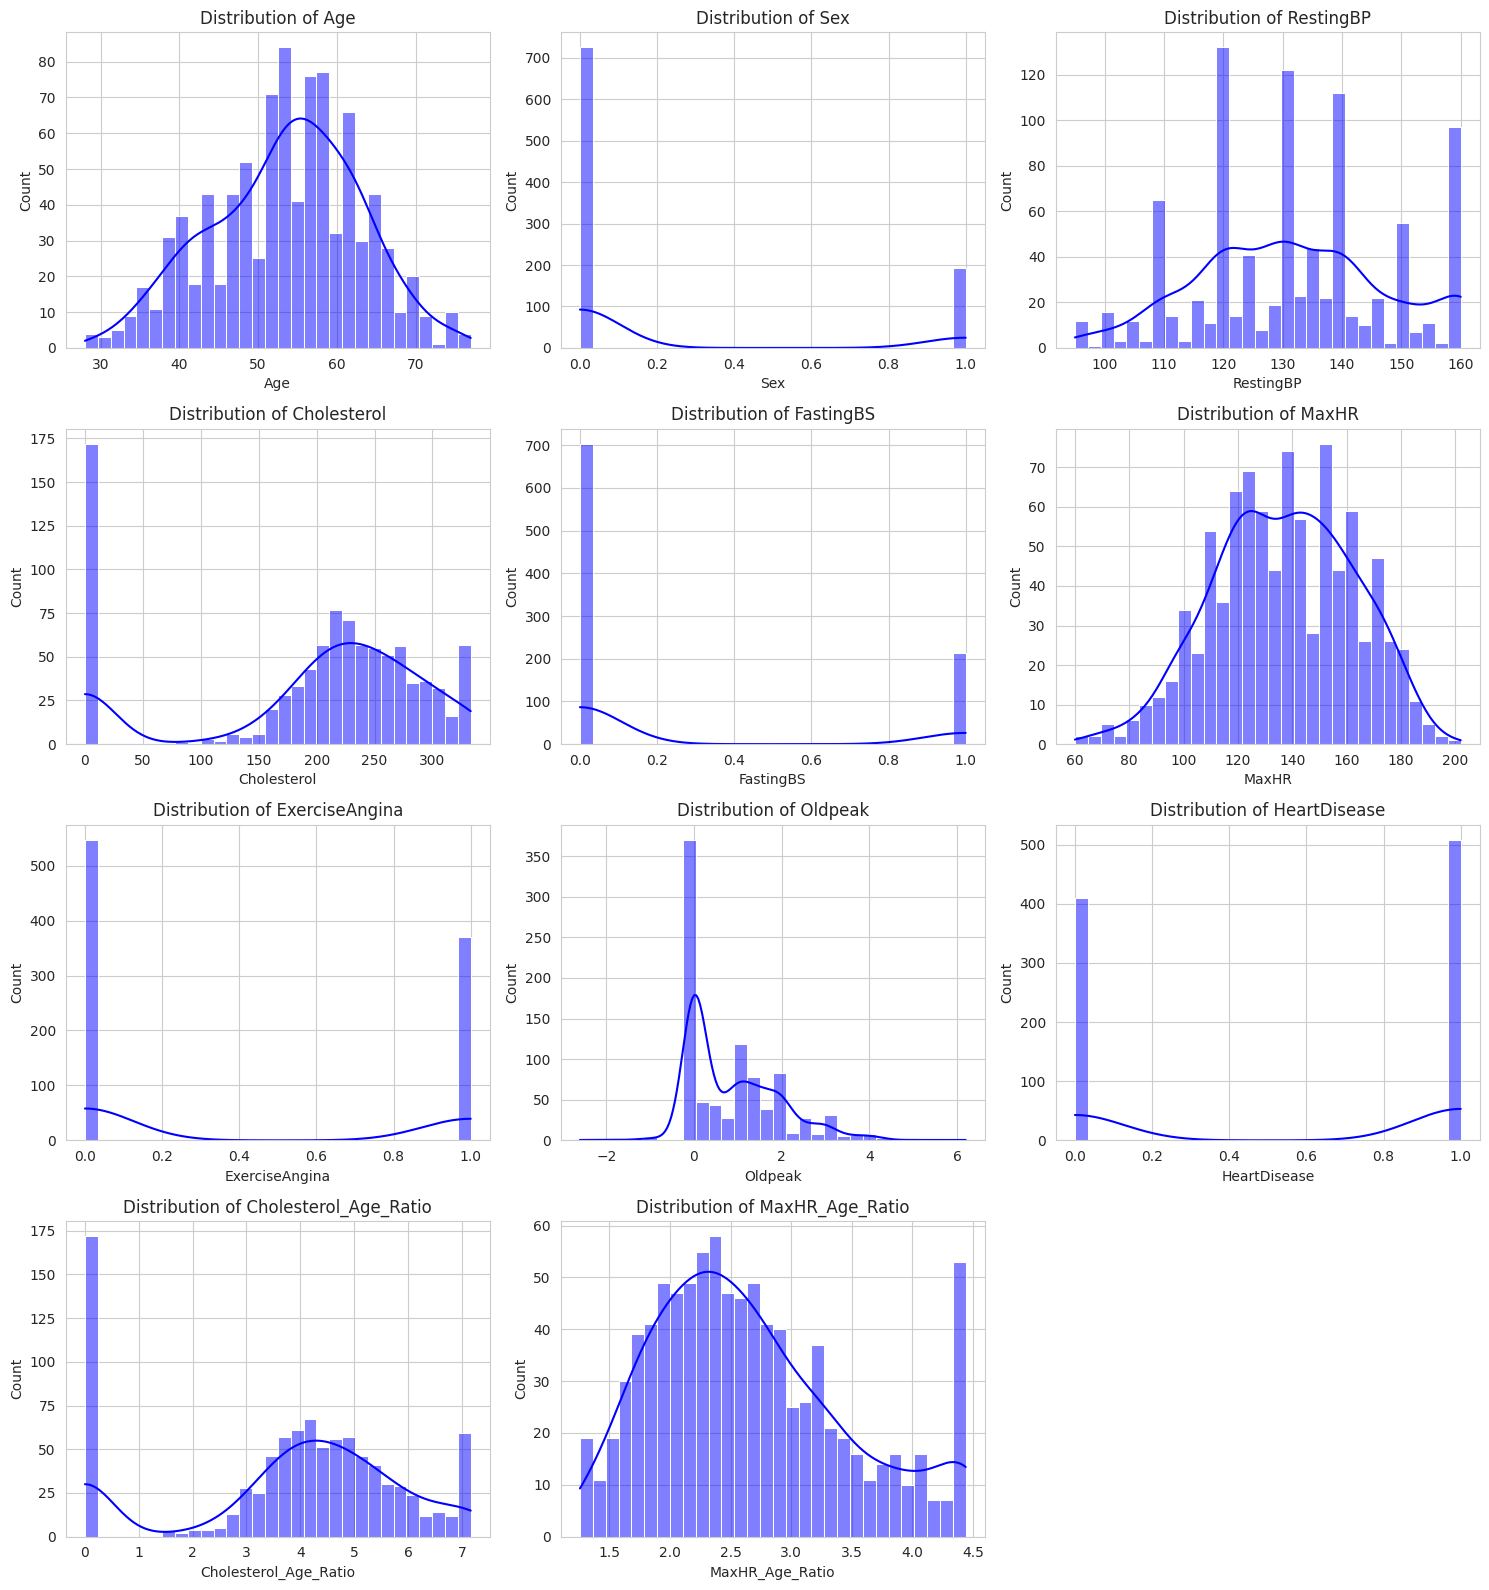

In [102]:
numerical_cols = data.select_dtypes(include=['int64', 'float64','bool']).columns


num_features = len(numerical_cols)
num_rows = int(np.ceil(num_features / 3))

plt.figure(figsize=(15, num_rows * 4))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(num_rows, 3, i)
    sns.histplot(data[col], bins=30, kde=True, color='blue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

# EDA (Exploratory Data Analysis)

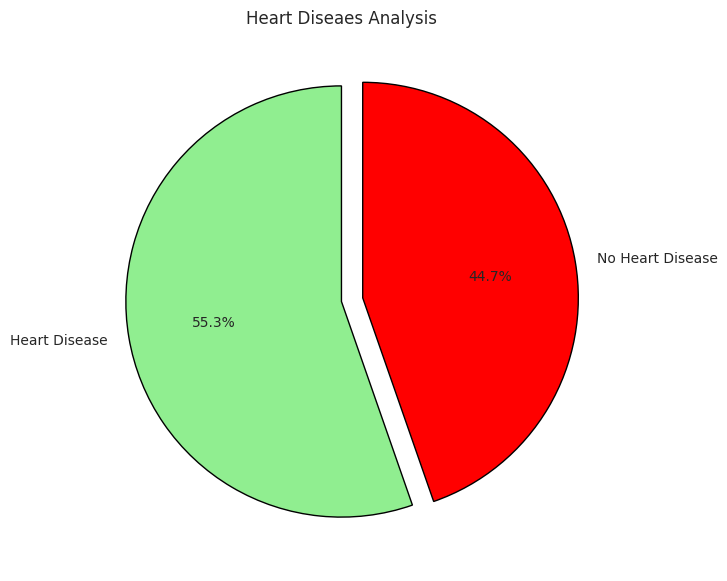

In [103]:
Heart_counts = data['HeartDisease'].value_counts()

labels = ['Heart Disease', 'No Heart Disease']


colors = ['lightgreen','red']

plt.figure(figsize=(7, 7))
plt.pie(Heart_counts, labels=labels, autopct='%1.1f%%', colors=colors, explode=[0, 0.1], startangle=90, wedgeprops={'edgecolor': 'black'})

# Title
plt.title('Heart Diseaes Analysis')

# Show plot
plt.show()

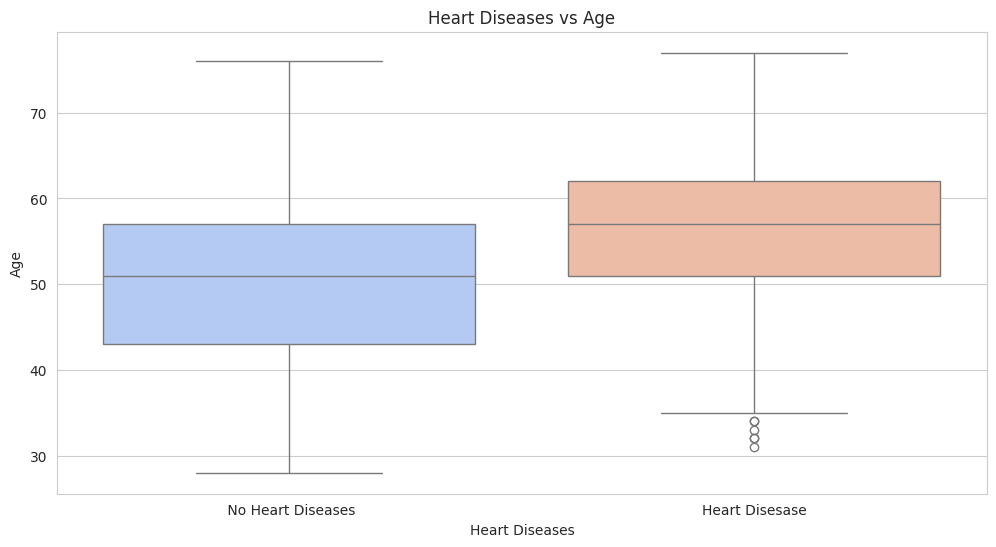

In [104]:
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='HeartDisease', y='Age', data=data, palette="coolwarm")
plt.xlabel('Heart Diseases')
plt.ylabel('Age')
plt.title('Heart Diseases vs Age')
plt.xticks([1,0],['Heart Disesase', ' No Heart Diseases'])
plt.show()

In [105]:
# T-Test: Are Heart Diseases significant across age groups or is it only due to random chance?
t_stat, p_value = stats.ttest_ind(
    data[data['HeartDisease'] == 1]['Age'],
    data[data['HeartDisease'] == 0]['Age'],
    equal_var=False
)
print(f"T-Test: Heart Disease vs Age \nT-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")

T-Test: Heart Disease vs Age 
T-Statistic: 8.8225, P-Value: 0.0000


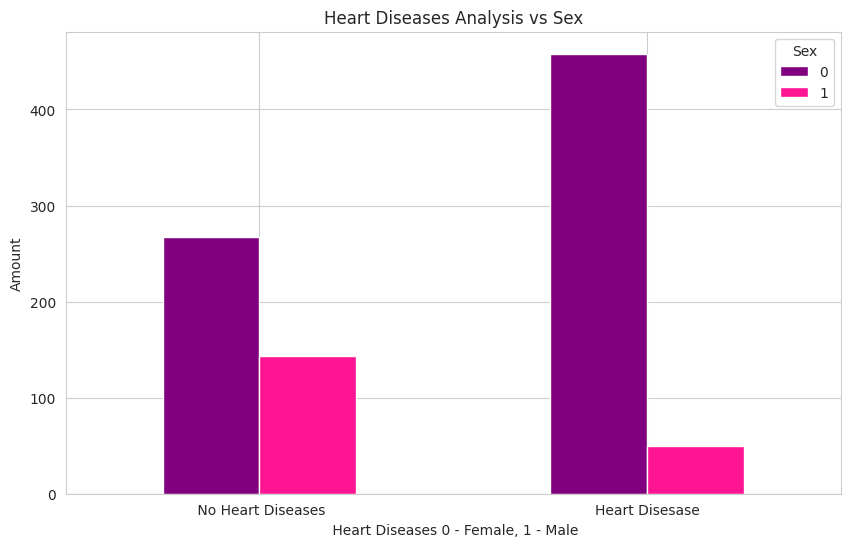

In [106]:
pd.crosstab(data.HeartDisease,data.Sex).plot(kind='bar',
                                       figsize=(10,6),
                                       color=['purple','deeppink'])
plt.title('Heart Diseases Analysis vs Sex')
plt.xlabel(' Heart Diseases 0 - Female, 1 - Male')
plt.ylabel('Amount')
plt.xticks(rotation=0)
plt.xticks([1,0],['Heart Disesase', ' No Heart Diseases'])
plt.show()

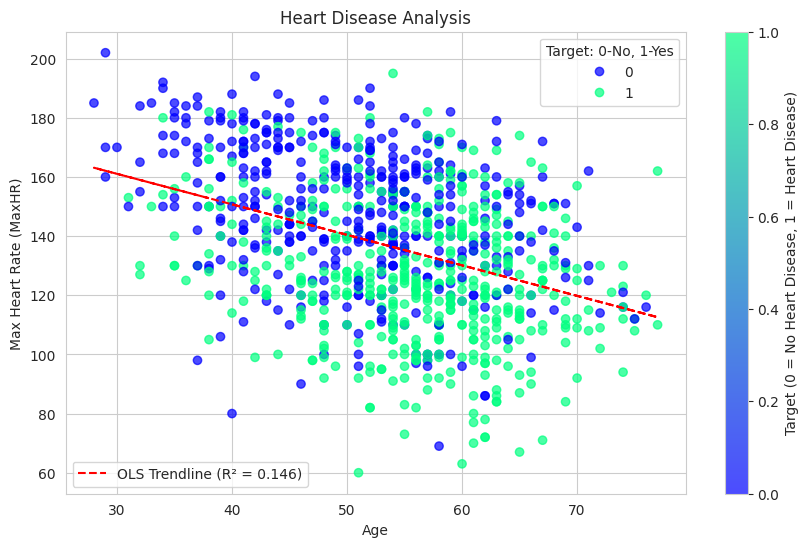

In [107]:
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot
scatter = ax.scatter(data["Age"],
                      data["MaxHR"],
                      c=data['HeartDisease'],
                      cmap='winter',
                      alpha=0.7)

# Calculate OLS regression
slope, intercept, r_value, p_value, std_err = linregress(data["Age"], data["MaxHR"])
line = slope * data["Age"] + intercept

# Plot OLS line
ax.plot(data["Age"], line, color='red', linestyle='--',
        label=f'OLS Trendline (R² = {r_value**2:.3f})')

# Title and labels
ax.set(title="Heart Disease Analysis",
       xlabel='Age',
       ylabel="Max Heart Rate (MaxHR)")

# Add legend for OLS Trendline
ols_legend = ax.legend(loc='lower left')

# Add legend for scatterplot colors
scatter_legend = ax.legend(*scatter.legend_elements(), title='Target: 0-No, 1-Yes', loc='upper right')

# Re-add OLS legend to the plot (so both legends display)
ax.add_artist(ols_legend)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Target (0 = No Heart Disease, 1 = Heart Disease)")

plt.show()

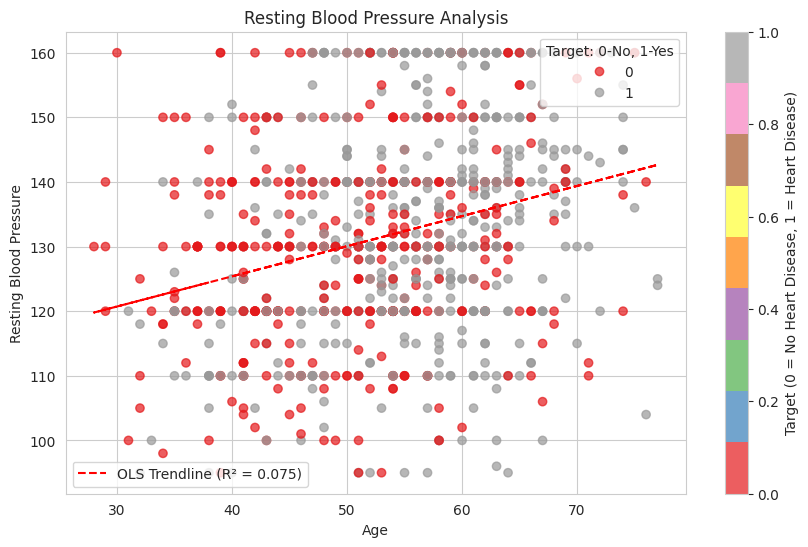

In [108]:
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot
scatter = ax.scatter(data["Age"],
                      data["RestingBP"],
                      c=data['HeartDisease'],
                      cmap='Set1',
                      alpha=0.7)

# Calculate OLS regression
slope, intercept, r_value, p_value, std_err = linregress(data["Age"], data["RestingBP"])
line = slope * data["Age"] + intercept

# Plot OLS line
ax.plot(data["Age"], line, color='red', linestyle='--',
        label=f'OLS Trendline (R² = {r_value**2:.3f})')

# Title and labels
ax.set(title="Resting Blood Pressure Analysis",
       xlabel='Age',
       ylabel="Resting Blood Pressure")

# Add legend for OLS Trendline
ols_legend = ax.legend(loc='lower left')

# Add legend for scatterplot colors
scatter_legend = ax.legend(*scatter.legend_elements(), title='Target: 0-No, 1-Yes', loc='upper right')

# Re-add OLS legend to the plot (so both legends display)
ax.add_artist(ols_legend)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Target (0 = No Heart Disease, 1 = Heart Disease)")

plt.show()

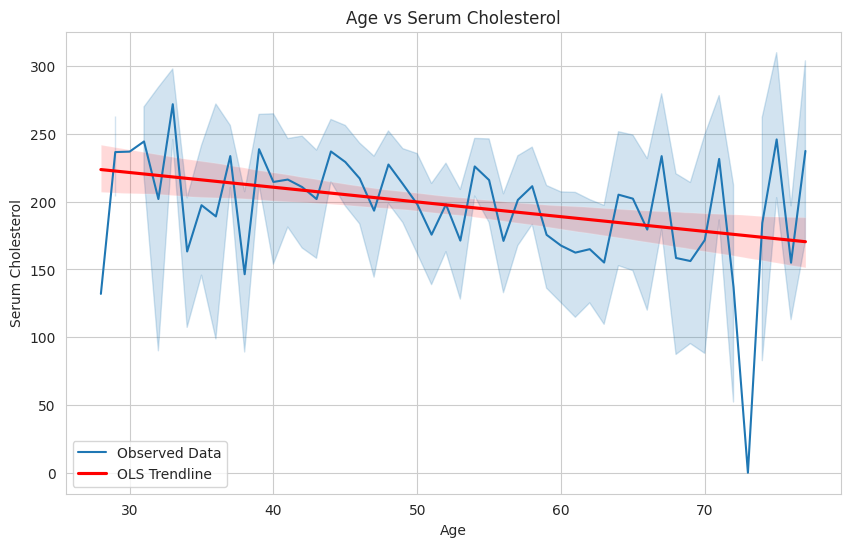

In [109]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Age',y='Cholesterol',data=data, label='Observed Data')
sns.regplot(x='Age', y='Cholesterol', data=data, scatter=False, color='red', label="OLS Trendline")
plt.title("Age vs Serum Cholesterol")
plt.xlabel("Age")
plt.ylabel("Serum Cholesterol")
plt.legend()
plt.show()

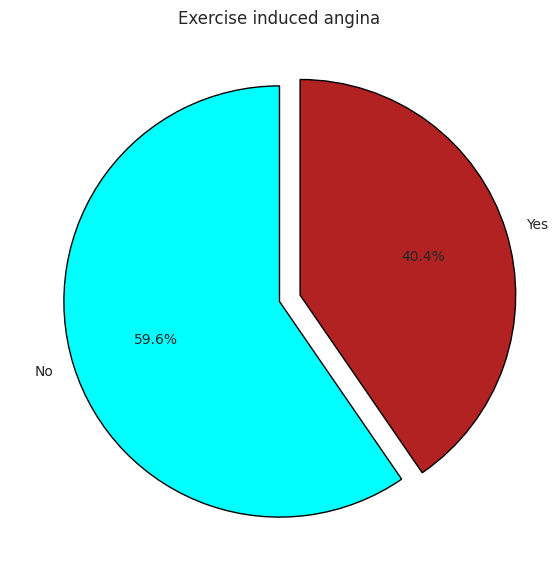

In [110]:
angina_count = data['ExerciseAngina'].value_counts()

labels = ["No", "Yes"]


colors = ['cyan','firebrick']

plt.figure(figsize=(7, 7))
plt.pie(angina_count, labels=labels, autopct='%1.1f%%', colors=colors, explode=[0, 0.1], startangle=90, wedgeprops={'edgecolor': 'black'})

# Title
plt.title('Exercise induced angina')

# Show plot
plt.show()

# Check The Distribution for the Spread of  the data


# Chest Pain by Cholestrol Level

0 - Typical angina:  Chest pain related to decrease in blood supply to the heart

1 - Atypical angina: Chest pain not related to heart

2 - Non anginal Pain: Typical esophageal Spasms(non heart related)

3 - Asymptomatic: Chest Pain not showing sign of diseases


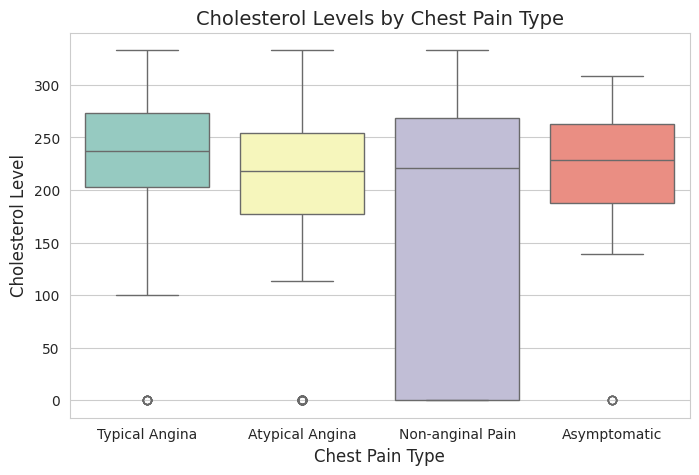

In [111]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="ChestPainType", y="Cholesterol", data=data, palette="Set3")
plt.xlabel("Chest Pain Type", fontsize=12)
plt.ylabel("Cholesterol Level", fontsize=12)
plt.title("Cholesterol Levels by Chest Pain Type", fontsize=14)
plt.xticks([0,1,2,3], ['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])
plt.show()

0.0	No ST depression	✅ Normal heart function

1.0 - 2.0	Mild ST depression	⚠️ Potential heart stress

2.0 or more	Significant ST depression	🚨 High risk of heart disease

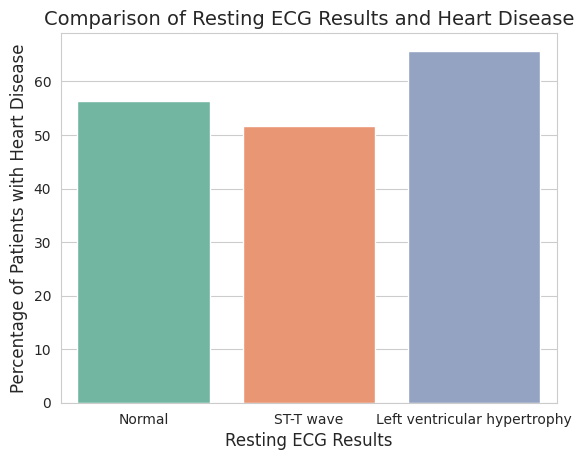

In [112]:
count_ECG = data.groupby("RestingECG")["HeartDisease"].mean() * 100

count_ECG_df = count_ECG.reset_index()
count_ECG_df.columns = ["RestingECG", "HeartDisease Percentage"]

ax = sns.barplot(x="RestingECG", y="HeartDisease Percentage", data=count_ECG_df, palette="Set2")

plt.xlabel("Resting ECG Results", fontsize=12)
plt.ylabel("Percentage of Patients with Heart Disease", fontsize=12)
plt.title("Comparison of Resting ECG Results and Heart Disease", fontsize=14)


plt.xticks([0,1,2], ['Normal', 'ST-T wave', 'Left ventricular hypertrophy'])

plt.show()

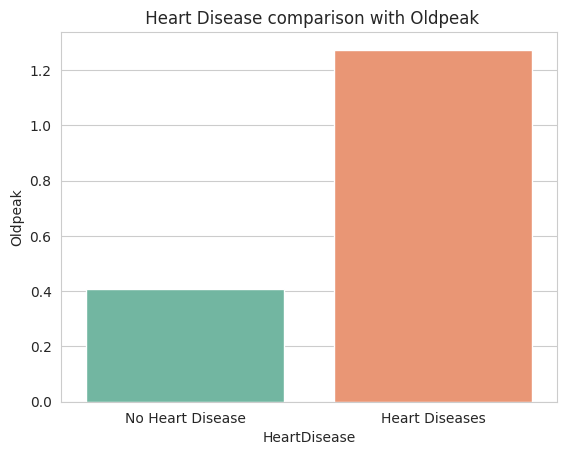

In [113]:
old_peak = data.groupby("HeartDisease")["Oldpeak"].mean()
old_peak_df = old_peak.reset_index()
old_peak_df.columns = ["HeartDisease", "Oldpeak"]

ax = sns.barplot(x="HeartDisease", y="Oldpeak", data=old_peak_df, palette="Set2")
plt.title(" Heart Disease comparison with Oldpeak")
plt.xticks([0,1],['No Heart Disease','Heart Diseases'])
plt.show()

In [114]:
data = pd.get_dummies(data, columns=['ChestPainType', 'RestingECG', 'ST_Slope'],drop_first=True)

AgeGroup_order = CategoricalDtype(categories=['Young', 'Middle-aged', 'Senior'], ordered=True)

data['Age_bracket'] = data['AgeGroup'].astype(AgeGroup_order)

data['Age_bracket'] = data['Age_bracket'].cat.codes

In [115]:
data['Age_bracket'].value_counts()

,count
Age_bracket,
1,604
2,221
0,93


In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    918 non-null    int64  
 1   Sex                    918 non-null    int64  
 2   RestingBP              918 non-null    int64  
 3   Cholesterol            918 non-null    int64  
 4   FastingBS              918 non-null    int64  
 5   MaxHR                  918 non-null    int64  
 6   ExerciseAngina         918 non-null    int64  
 7   Oldpeak                918 non-null    float64
 8   HeartDisease           918 non-null    int64  
 9   Cholesterol_Age_Ratio  918 non-null    float64
 10  MaxHR_Age_Ratio        918 non-null    float64
 11  AgeGroup               918 non-null    object 
 12  Age_bracket            918 non-null    int8   
 13  ChestPainType_ATA      918 non-null    bool   
 14  ChestPainType_NAP      918 non-null    bool   
 15  ChestP

In [117]:
data.drop(columns=['AgeGroup'],axis=1, inplace=True)

# Correlation Matrix

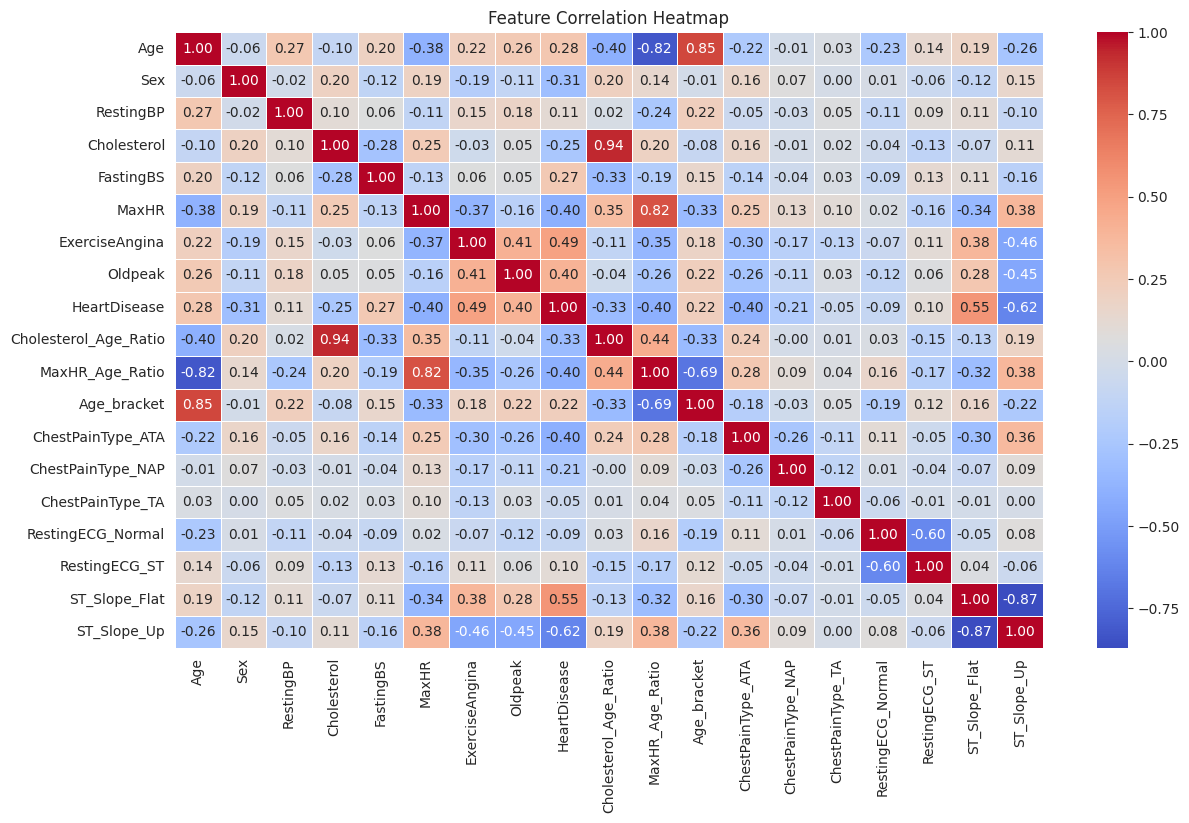

In [118]:
corr_matrix = data.corr()

plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

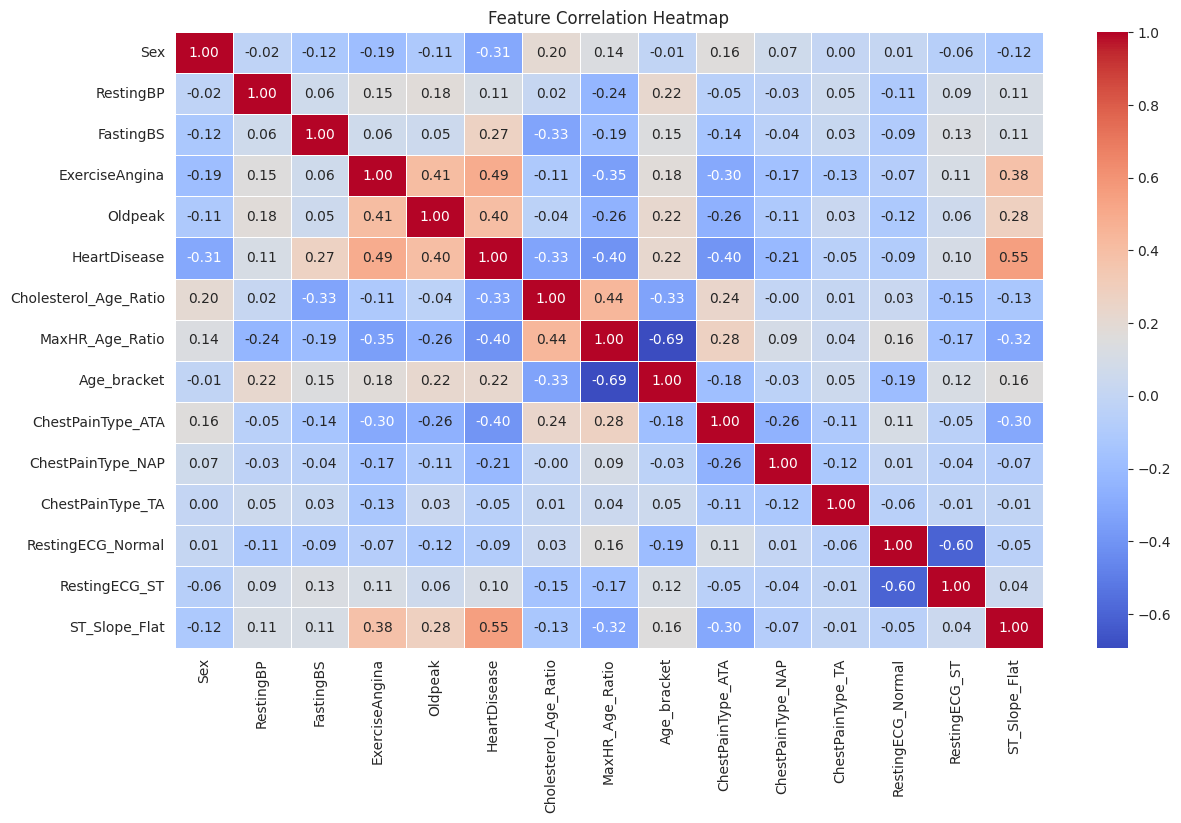

In [121]:
corr_matrix = data.corr()

plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [122]:
X = data.drop('HeartDisease',axis=1)

y = data['HeartDisease']

In [123]:
np.random.seed(42)

# split into train and test set

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

**Feature Importance using Random Forest model**

In [124]:
# model_test = RandomForestClassifier(n_estimators=100, random_state=42)
# model_test.fit(X_train, y_train)

# # Get feature importance scores
# feature_importance = model_test.feature_importances_
# feature_names = X_train.columns

# # Display importance in descending order
# sorted_idx = np.argsort(feature_importance)[::-1]
# for i in sorted_idx[:10]:  # Show top 10
#     print(f"{feature_names[i]}: {feature_importance[i]:.4f}")

# plt.figure(figsize=(12, 6))
# sns.barplot(x=feature_importance[sorted_idx], y=[feature_names[i] for i in sorted_idx], palette="viridis")
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
# plt.title('Feature Importance of House Price Prediction Model')
# plt.show()

In [125]:
data.to_csv("cleaned_data.csv", index=False)

# Modeling

In [126]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [127]:
X_train_scaled

array([[-0.54060477, -0.77753641,  1.84260945, ...,  0.80817891,
        -0.48762079, -1.03325003],
       [-0.54060477, -0.14761177, -0.5427086 , ...,  0.80817891,
        -0.48762079, -1.03325003],
       [-0.54060477,  1.11223752,  1.84260945, ...,  0.80817891,
        -0.48762079,  0.96781995],
       ...,
       [-0.54060477, -0.14761177, -0.5427086 , ...,  0.80817891,
        -0.48762079, -1.03325003],
       [-0.54060477,  1.23822244, -0.5427086 , ..., -1.23734978,
         2.05077394, -1.03325003],
       [ 1.84978019,  1.11223752, -0.5427086 , ...,  0.80817891,
        -0.48762079,  0.96781995]])

In [128]:
X_test_scaled

array([[ 1.84978019,  0.48231287, -0.5427086 , ...,  0.80817891,
        -0.48762079, -1.03325003],
       [-0.54060477,  0.79727519, -0.5427086 , ...,  0.80817891,
        -0.48762079,  0.96781995],
       [-0.54060477,  1.74216216,  1.84260945, ..., -1.23734978,
         2.05077394,  0.96781995],
       ...,
       [-0.54060477,  0.54530534,  1.84260945, ..., -1.23734978,
         2.05077394,  0.96781995],
       [-0.54060477, -0.14761177, -0.5427086 , ...,  0.80817891,
        -0.48762079, -1.03325003],
       [-0.54060477,  0.73428273, -0.5427086 , ..., -1.23734978,
         2.05077394,  0.96781995]])

# Handling Class Imbalance

In [129]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Model Building

## Base Line Models


In [130]:
models = {
    "LogisticRegression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "LightGBM": LGBMClassifier(verbosity=-1),
    "CatBoost": CatBoostClassifier(verbose=0)
}

In [131]:
def fit_and_score(models, X_train_smote, X_test_scaled, y_train_smote, y_test):
    np.random.seed(42)
    model_scores = {}
    fitted_models = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        model.fit(X_train_smote, y_train_smote)

        fitted_models[name] = model

        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
        roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

        model_scores[name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "ROC AUC": roc_auc if roc_auc is not None else "N/A"
        }

        print(f"\nModel: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        if roc_auc is not None:
            print(f"ROC AUC Score: {roc_auc:.4f}")

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

    return model_scores, fitted_models

In [132]:
model_scores, fitted_models = fit_and_score(models, X_train_smote, X_test_scaled, y_train_smote, y_test)


Training LogisticRegression...

Model: LogisticRegression
Accuracy: 0.8533
Precision: 0.9167
Recall: 0.8224
F1 Score: 0.8670
ROC AUC Score: 0.9284

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84        77
           1       0.92      0.82      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184


Training KNN...

Model: KNN
Accuracy: 0.5815
Precision: 0.5815
Recall: 1.0000
F1 Score: 0.7354
ROC AUC Score: 0.5000

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.58      1.00      0.74       107

    accuracy                           0.58       184
   macro avg       0.29      0.50      0.37       184
weighted avg       0.34      0.58      0.43       184


Training Random Forest...

Mode

# Model Comparison

In [133]:
def evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, model_name):
    y_train_pred = model.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    y_test_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    overall_accuracy = (train_accuracy + test_accuracy) / 2

    if hasattr(model, "predict_proba"):
        y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    else:
        roc_auc = None

    return pd.DataFrame({
        'Model': [model_name],
        'Train Accuracy': [train_accuracy],
        'Test Accuracy': [test_accuracy],
        'Overall Accuracy': [overall_accuracy],
        'ROC AUC': [roc_auc]
    })

results = pd.DataFrame()
for name, model in fitted_models.items():
    results = pd.concat([results, evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)], ignore_index=True)

results.set_index('Model', inplace=True)
results = results.round(4)

print("\nModel Comparison:")
display(results)


Model Comparison:


,Train Accuracy,Test Accuracy,Overall Accuracy,ROC AUC
Model,,,,
LogisticRegression,0.8542,0.8533,0.8537,0.9284
KNN,0.5463,0.5815,0.5639,0.5000
Random Forest,0.8338,0.8207,0.8272,0.9036
Gradient Boosting,0.8174,0.7935,0.8055,0.8910
AdaBoost,0.8297,0.8424,0.8360,0.9101
LightGBM,0.8488,0.8478,0.8483,0.9165
CatBoost,0.8501,0.8478,0.8490,0.9238


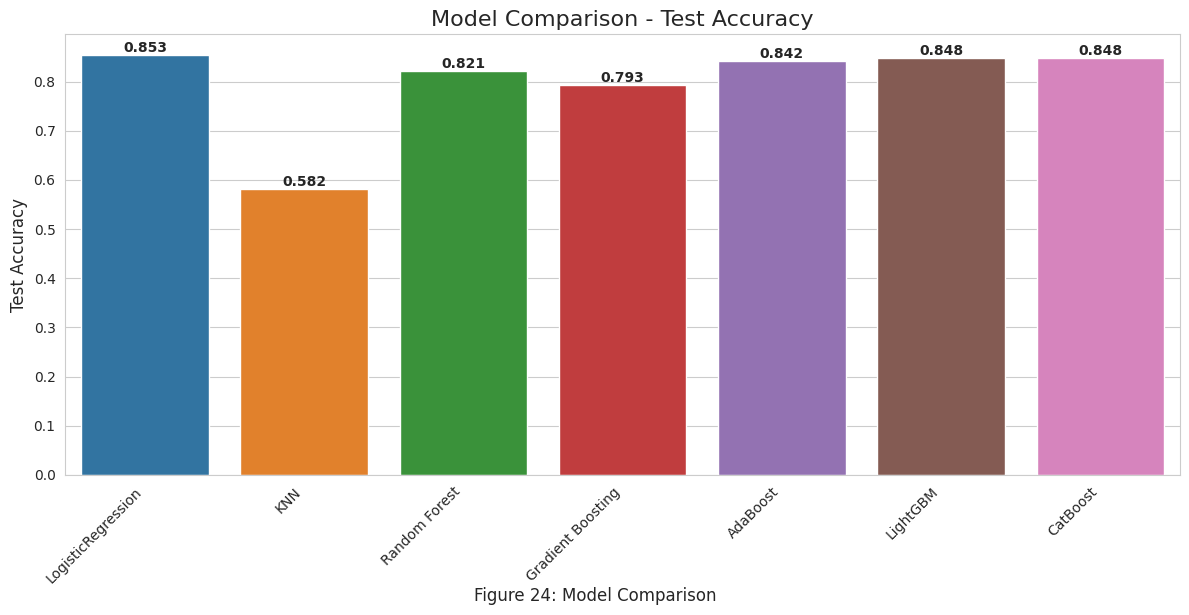

In [134]:
plt.figure(figsize=(12, 6))
plot_data = pd.DataFrame({
    'Model': results.index,
    'Test Accuracy': results['Test Accuracy']
})
ax = sns.barplot(x='Model', y='Test Accuracy', data=plot_data, hue='Model', dodge=False)
plt.title('Model Comparison - Test Accuracy', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=12)
ax.set_xlabel(None)
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(plot_data['Test Accuracy']):
    ax.text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.figtext(0.5, -0.01, 'Figure 24: Model Comparison', ha='center', fontsize=12)
plt.show()

In [136]:
tuned_models = {
    "Logistic Regression": {
        'model': LogisticRegression(),
        'params': {
            'fit_intercept': [True, False],
            'solver': ['lbfgs', 'liblinear']
        }
    },

    "CatBoost": {
        'model': CatBoostClassifier(verbose=0),
        'params': {
            'iterations': [100, 300, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'depth': [3, 4, 5],
            'l2_leaf_reg': [5, 10],
            'boosting_type': ['Ordered', 'Plain']
        }
    },

    "LightGBM": {
        'model': LGBMClassifier(verbose=-1),
        'params': {
            'n_estimators': [100, 300, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [10, 20, 30],
            'max_depth': [3, 6, 9],
            'boosting_type': ['gbdt', 'dart']
        }
    },

    "KNN": {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [5, 10, 15],
            'weights': ['uniform', 'distance'],
            'metric': ['minkowski'],
            'p': [1, 2]
        }
    },

    "Random Forest": {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 150, 300],
            'max_depth': [6, 10, 15],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4],
            'bootstrap': [True, False]
        }
    },

    "Gradient Boosting": {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [100, 300, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'min_samples_split': [5, 10],
            'subsample': [0.7, 0.9]
        }
    },

    "AdaBoost": {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [100, 200, 400],
            'learning_rate': [0.01, 0.05, 0.1],
            'algorithm': ['SAMME', 'SAMME.R']
        }
    }
}


In [137]:
def fit_models_with_grid_search(tuned_models, X_train_smote, X_test_scaled, y_train_smote, y_test):
    """
    Fits models using GridSearchCV and evaluates them.
    """
    np.random.seed(42)
    model_scores_1 = {}
    fitted_models_1 = {}

    for name, model_info in tuned_models.items():
        print(f"\n🔍 Optimizing {name} with Grid Search...")

        grid_search = GridSearchCV(
            estimator=model_info['model'],
            param_grid=model_info['params'],
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )

        grid_search.fit(X_train_smote, y_train_smote)
        best_model = grid_search.best_estimator_
        fitted_models_1[name] = best_model

        y_pred = best_model.predict(X_test_scaled)
        y_prob = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, "predict_proba") else None

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
        roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"

        model_scores_1[name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "ROC AUC": roc_auc
        }

        print(f"\n✅ Best Model: {name}")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        if y_prob is not None:
            print(f"ROC AUC Score: {roc_auc:.4f}")

    return model_scores_1, fitted_models_1


In [138]:
print("Starting hyperparameter tuning...")
model_scores_1, fitted_models_1 = fit_models_with_grid_search(tuned_models, X_train_smote, X_test_scaled, y_train_smote, y_test)

Starting hyperparameter tuning...

🔍 Optimizing Logistic Regression with Grid Search...

✅ Best Model: Logistic Regression
Best Parameters: {'fit_intercept': True, 'solver': 'liblinear'}
Accuracy: 0.8587
Precision: 0.9263
Recall: 0.8224
F1 Score: 0.8713
ROC AUC Score: 0.9272

🔍 Optimizing CatBoost with Grid Search...

✅ Best Model: CatBoost
Best Parameters: {'boosting_type': 'Plain', 'depth': 3, 'iterations': 300, 'l2_leaf_reg': 10, 'learning_rate': 0.05}
Accuracy: 0.8696
Precision: 0.8673
Recall: 0.9159
F1 Score: 0.8909
ROC AUC Score: 0.9261

🔍 Optimizing LightGBM with Grid Search...

✅ Best Model: LightGBM
Best Parameters: {'boosting_type': 'dart', 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 500, 'num_leaves': 10}
Accuracy: 0.8967
Precision: 0.8929
Recall: 0.9346
F1 Score: 0.9132
ROC AUC Score: 0.9273

🔍 Optimizing KNN with Grid Search...

✅ Best Model: KNN
Best Parameters: {'metric': 'minkowski', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Accuracy: 0.5870
Precision:

In [139]:
def evaluate_model_grid_search(best_model, X_train_smote, X_test_scaled, y_train_smote, y_test, model_name):

    y_train_pred = best_model.predict(X_train_smote)
    y_test_pred = best_model.predict(X_test_scaled)

    train_accuracy = accuracy_score(y_train_smote, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    overall_accuracy = (train_accuracy + test_accuracy) / 2

    precision = precision_score(y_test, y_test_pred, average='binary')
    recall = recall_score(y_test, y_test_pred, average='binary')
    f1 = f1_score(y_test, y_test_pred, average='binary')

    if hasattr(best_model, "predict_proba"):
        y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
        roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    else:
        roc_auc = "N/A"

    return pd.DataFrame({
        'Model': [model_name],
        'Train Accuracy': [train_accuracy],
        'Test Accuracy': [test_accuracy],
        'Overall Accuracy': [overall_accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
        'ROC AUC': [roc_auc]
    })

results = pd.DataFrame()

for name, best_model in fitted_models_1.items():
    results = pd.concat([results, evaluate_model_grid_search(
        best_model, X_train_smote, X_test_scaled, y_train_smote, y_test, name
    )], ignore_index=True)

results.set_index('Model', inplace=True)

results = results.round(4)

print("\nModel Comparison After Hyperparameter Tuning:")
display(results)


Model Comparison After Hyperparameter Tuning:


,Train Accuracy,Test Accuracy,Overall Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,,,
Logistic Regression,0.8703,0.8587,0.8645,0.9263,0.8224,0.8713,0.9272
CatBoost,0.9327,0.8696,0.9011,0.8673,0.9159,0.8909,0.9261
LightGBM,0.9539,0.8967,0.9253,0.8929,0.9346,0.9132,0.9273
KNN,1.0000,0.5870,0.7935,0.5847,1.0000,0.7379,0.7725
Random Forest,0.9451,0.8315,0.8883,0.8065,0.9346,0.8658,0.9144
Gradient Boosting,0.9763,0.8261,0.9012,0.8000,0.9346,0.8621,0.8763
AdaBoost,0.8778,0.8533,0.8655,0.8333,0.9346,0.8811,0.9113


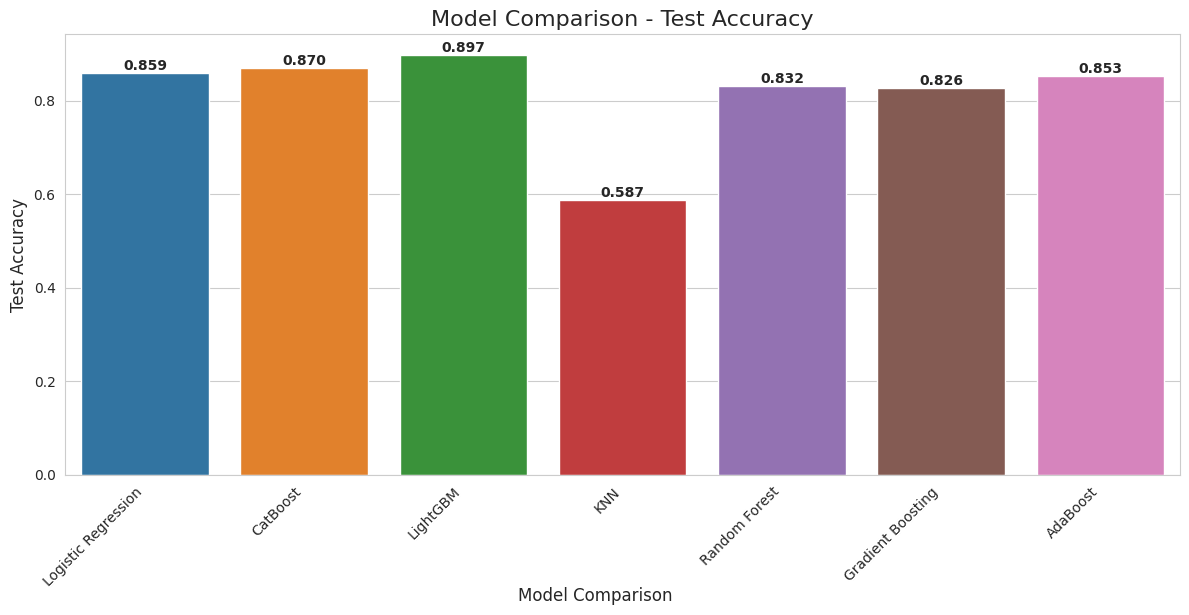

In [140]:
plt.figure(figsize=(12, 6))
plot_data = pd.DataFrame({
    'Model': results.index,
    'Test Accuracy': results['Test Accuracy']
})
ax = sns.barplot(x='Model', y='Test Accuracy', data=plot_data, hue='Model', dodge=False)
plt.title('Model Comparison - Test Accuracy', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=12)
ax.set_xlabel(None)
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(plot_data['Test Accuracy']):
    ax.text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.figtext(0.5, -0.01, 'Model Comparison', ha='center', fontsize=12)
plt.show()

In [151]:
LightGBM = fitted_models_1.get("LightGBM")

In [152]:
best_model = fitted_models["LightGBM"]

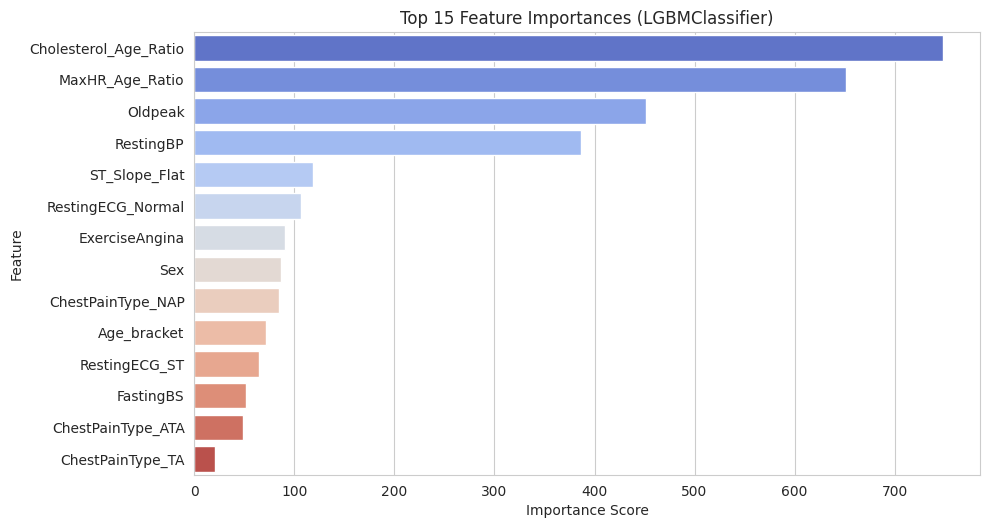


Top 15 Most Important Features:
                  Feature  Importance
5   Cholesterol_Age_Ratio         748
6         MaxHR_Age_Ratio         651
4                 Oldpeak         451
1               RestingBP         387
13          ST_Slope_Flat         119
11      RestingECG_Normal         107
3          ExerciseAngina          91
0                     Sex          87
9       ChestPainType_NAP          85
7             Age_bracket          72
12          RestingECG_ST          65
2               FastingBS          52
8       ChestPainType_ATA          49
10       ChestPainType_TA          21


In [153]:
def get_feature_importance(model, feature_names):
    """
    Extract feature importance for regression models.
    - For linear models: Uses absolute coefficients.
    - For tree-based models: Uses feature_importances_ attribute.
    """
    if hasattr(model, 'coef_'):
        importance_values = np.abs(model.coef_)

        if importance_values.ndim > 1:
            importance_values = np.mean(importance_values, axis=0)

    elif hasattr(model, 'feature_importances_'):
        importance_values = model.feature_importances_

    else:
        print(f"{model.__class__.__name__} doesn't support feature importance extraction.")
        return None

    return pd.DataFrame({'Feature': feature_names, 'Importance': importance_values}).sort_values(by='Importance', ascending=False)

original_feature_names = X_train.columns.tolist()

feature_importance = get_feature_importance(best_model, original_feature_names)

if feature_importance is not None:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15),
                hue="Feature", dodge=False, legend=False, palette="coolwarm")

    plt.title(f'Top 15 Feature Importances ({best_model.__class__.__name__})')
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.show()

    print("\nTop 15 Most Important Features:")
    print(feature_importance.head(15))
else:
    print("\nFeature importance not available for this model type.")

In [155]:
def plot_confusion_matrix_nba(model, X_test_scaled, y_test, model_name="LightGBM"):
    """
    Generate and display the confusion matrix for a trained NBA shot prediction model.
    """
    y_pred = model.predict(X_test_scaled)

    cm = confusion_matrix(y_test, y_pred)

    class_labels = ["0 (Miss)", "1 (Made)"]

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, cbar=False)

    ax.set_title(f'{model_name} - Confusion Matrix (Test Data)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('Actual Label', fontsize=12)

    ax.set_xticklabels(class_labels, fontsize=10)
    ax.set_yticklabels(class_labels, fontsize=10)

    plt.subplots_adjust(bottom=0.25)
    plt.figtext(0.5, -0.01, 'Figure 30: Confusion Matrix', ha='center', fontsize=12)

    plt.show()

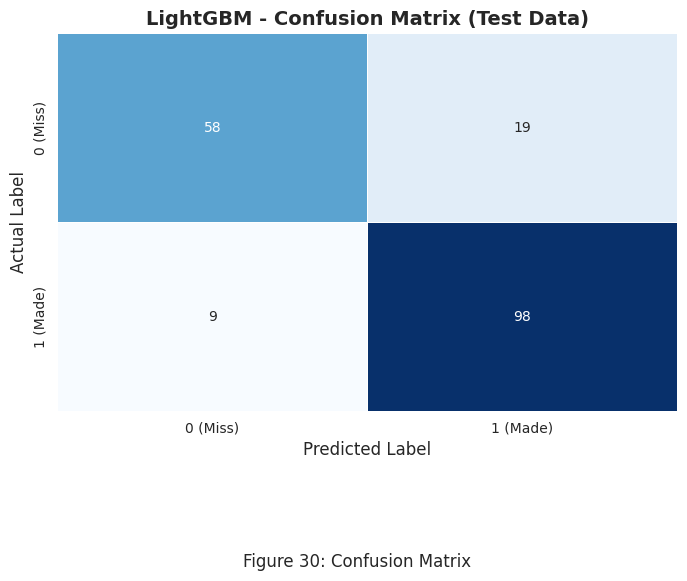

In [156]:
plot_confusion_matrix_nba(best_model, X_test_scaled, y_test, "LightGBM")

In [157]:
with open('LightGBM.pkl', 'wb') as f:
    pickle.dump(LightGBM, f)

print("Trained model saved successfully!")

Trained model saved successfully!


In [159]:
with open('StandardScalar.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("StandardScalar Saved!")

StandardScalar Saved!
